# Titanic survival prediction



In this notebook, I will make an attempt to predict the individuals who survived on the Titanic. The dataset we will be using comprises several features:

|  Variable   |          Definition          |              Key/Values                 |
|:-----------:|:----------------------------:|:---------------------------------------:|
| PassengerId | Index                        |integer                                  |
| Pclass      | Ticket class                 |1=1st, 2=2nd, 3=3rd                      |
| Name        | Name of passenger            |string                                   |
| Sex         | Sex                          |male, female                             |
| Age         | Age in years                 |integer                                  |
| SibSp       | # of siblings/spouses aboard |integer                                  |
| Parch       | # of parents/children aboard |integer                                  |
| Ticket      | Ticket number                |string                                   |
| Fare        | Ticket fare                  |float                                    |
| Cabin       | Cabin number                 |a code                                   |
| Embarked    | Port of Embarkation          |C=Cherbourg, Q=Queenstown, S=Southampton |
| **Survived**| Predicted varibale           |0=No, 1=Yes                              |


In [24]:
from itertools import combinations, product
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import random
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [26]:
#reading the data
df =pd.read_csv("titanic_train.csv")

In [27]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,315,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.2500,NaN,S,0
1,328,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,S,1
2,879,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S,0
3,288,3,"Naidenoff, Mr. Penko",male,22.0,0,0,349206,7.8958,NaN,S,0
4,280,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S,1


We have decided to remove the columns 'PassengerID' and 'Ticket' from the model as they contain unique values for each instance and are not expected to contribute to the predictive power of the model.

In [28]:
#droping irrelevant columns
irrelevant_cols = ['PassengerId', 'Ticket']  
df = df.drop(irrelevant_cols, axis=1)

## Exploratory Data Analysis

In [29]:
df.describe()

,Pclass,Age,SibSp,Parch,Fare,Survived
count,712.000000,569.000000,712.000000,712.000000,712.000000,712.000000
mean,2.306180,30.017873,0.492978,0.363764,32.183227,0.383427
std,0.837964,14.556518,1.121309,0.745153,48.431211,0.486563
min,1.000000,0.750000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.000000,0.000000,0.000000,7.895800,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.200000,0.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,3.000000,80.000000,8.000000,5.000000,512.329200,1.000000


It seems that there are no very massive outliers. However, there is a relatively high standard deviation in Age cloumn and in Fare cloumn - this seems reasonable, but we will have to research a little more to understand in depth.

### missing data

In [30]:
print("missing values by column:")
df.isnull().sum()

missing values by column:


Pclass        0
Name          0
Sex           0
Age         143
SibSp         0
Parch         0
Fare          0
Cabin       549
Embarked      2
Survived      0
dtype: int64

There are missing values in the Age and Cabin columns.

### Female VS Male

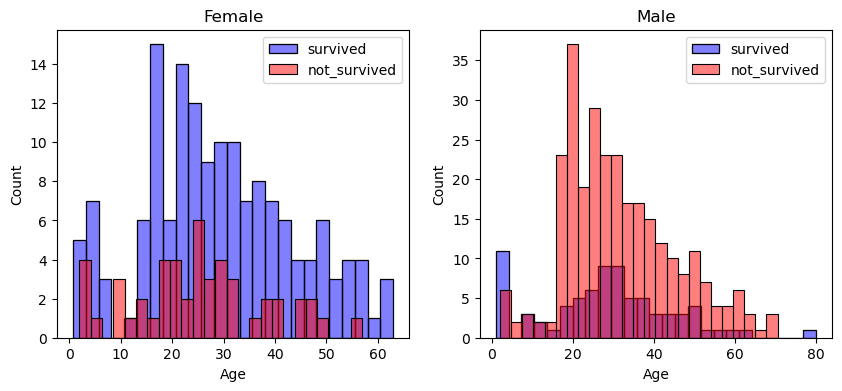

In [31]:
survived = 'survived'
not_survived = 'not_survived'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

women = df[df['Sex']=='female']
men = df[df['Sex']=='male']

sub = sns.histplot(women[women['Survived']==1].Age.dropna(), bins=25, label=survived, ax=axes[0], alpha=0.5, color='blue')
sub = sns.histplot(women[women['Survived']==0].Age.dropna(), bins=25, label=not_survived, ax=axes[0], alpha=0.5, color='red')
sub.legend()
sub.set_title('Female')

sub = sns.histplot(men[men['Survived']==1].Age.dropna(), bins=25, label=survived, ax=axes[1], alpha=0.5, color='blue')
sub = sns.histplot(men[men['Survived']==0].Age.dropna(), bins=25, label=not_survived, ax=axes[1], alpha=0.5, color='red')
sub.legend()
sub.set_title('Male')

plt.show()


Based on the plots, it appears that a higher proportion of females survived compared to males.We can see that females survived more than men.

### Survival by Pclass

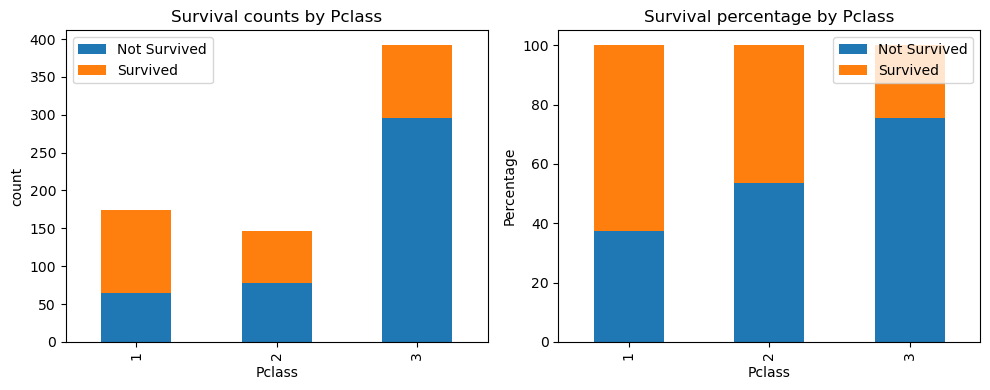

In [32]:
survival_counts = df.groupby(['Pclass', 'Survived']).size().unstack()
survival_counts_ps = survival_counts.apply(lambda x: x*100/x.sum(), axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

survival_counts.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Survival counts by Pclass')
axes[0].set_xlabel('Pclass')
axes[0].set_ylabel('count')
axes[0].legend(['Not Survived', 'Survived'])

survival_counts_ps.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Survival percentage by Pclass')
axes[1].set_xlabel('Pclass')
axes[1].set_ylabel('Percentage')
axes[1].legend(['Not Survived', 'Survived'])

plt.tight_layout()
plt.show()

Based on the plots, we can observe that the percentage of survival was highest in the first class, followed by the second class, and then the third class.

### Survival by SibSp and Parch

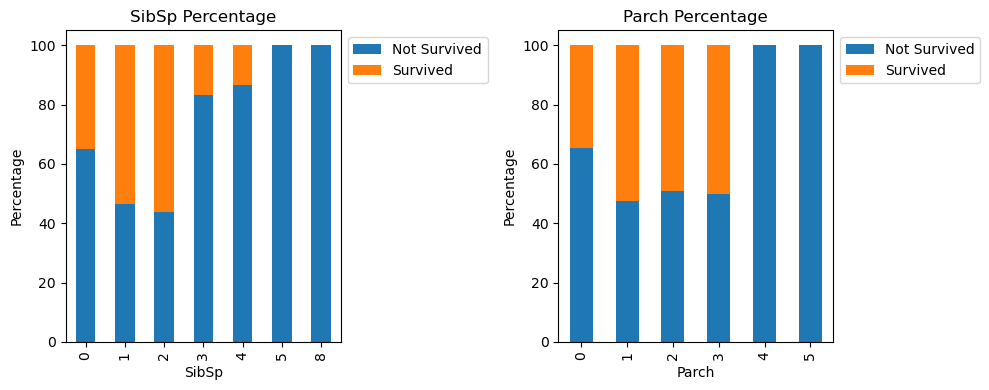

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sibsp_counts = df.groupby(['SibSp', 'Survived']).size().unstack()
sibsp_counts = sibsp_counts.apply(lambda x: x*100/x.sum(), axis=1)
sibsp_counts.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('SibSp Percentage')
axes[0].set_xlabel('SibSp')
axes[0].set_ylabel('Percentage')
axes[0].legend(['Not Survived', 'Survived'],bbox_to_anchor=(1,1))

parch_counts = df.groupby(['Parch', 'Survived']).size().unstack()
parch_counts = parch_counts.apply(lambda x: x*100/x.sum(), axis=1)
parch_counts.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Parch Percentage')
axes[1].set_xlabel('Parch')
axes[1].set_ylabel('Percentage')
axes[1].legend(['Not Survived', 'Survived'],bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

Higher proportion of passengers with large values of SibSp or Parch did not survive based on the plot.

### Survival by Embarked

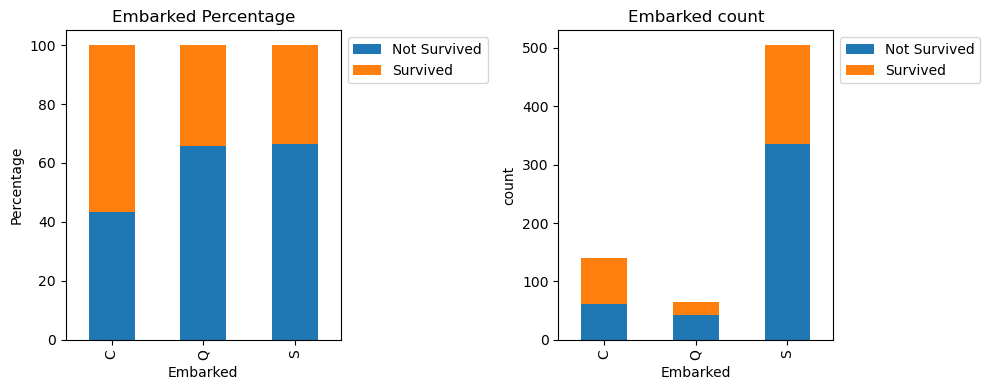

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

Embarked_counts = df.groupby(['Embarked', 'Survived']).size().unstack()
Embarked_counts_ps = Embarked_counts.apply(lambda x: x*100/x.sum(), axis=1)
Embarked_counts_ps.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Embarked Percentage')
axes[0].set_xlabel('Embarked')
axes[0].set_ylabel('Percentage')
axes[0].legend(['Not Survived', 'Survived'],bbox_to_anchor=(1,1))

Embarked_counts.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Embarked count')
axes[1].set_xlabel('Embarked')
axes[1].set_ylabel('count')
axes[1].legend(['Not Survived', 'Survived'],bbox_to_anchor=(1,1))


plt.tight_layout()
plt.show()

Based on the data, it appears that approximately half of the passengers who embarked at location C survived, while the percentage of survival was lower for those who embarked at locations Q and S. Additionally, it is worth noting that the majority of passengers in the dataset embarked at location S.

### Distribution of fare by survival

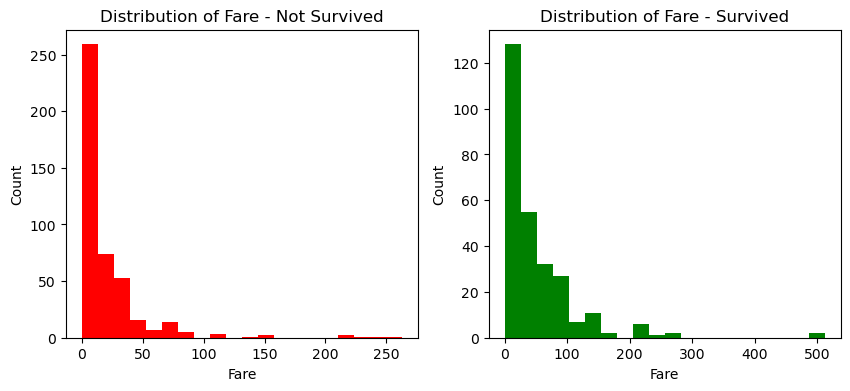

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
df_groupby = df.groupby('Survived')
axes[0].hist(df_groupby.get_group(0)['Fare'], bins=20, color='red')
axes[0].set_title('Distribution of Fare - Not Survived')
axes[0].set_xlabel('Fare')
axes[0].set_ylabel('Count')

axes[1].hist(df_groupby.get_group(1)['Fare'], bins=20, color='green')
axes[1].set_title('Distribution of Fare - Survived')
axes[1].set_xlabel('Fare')
axes[1].set_ylabel('Count')

plt.show()


Based on the plots, it appears that the distribution of fares for passengers who survived is wider than the distribution of fares for passengers who did not survive. This suggests that there may be a relationship between fare and survival, with higher fares potentially associated with higher chances of survival. also we can see that the distribution is skwed and has outliers. we will handle it later.

### Distribution of age by survival

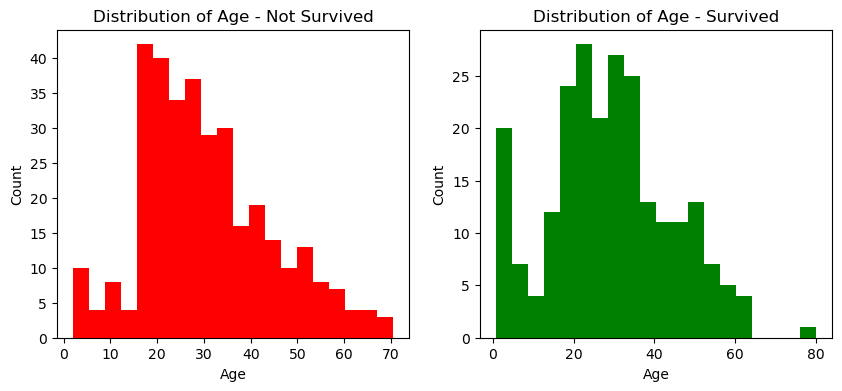

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
df_groupby = df.groupby('Survived')
axes[0].hist(df_groupby.get_group(0)['Age'], bins=20, color='red')
axes[0].set_title('Distribution of Age - Not Survived')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

axes[1].hist(df_groupby.get_group(1)['Age'], bins=20, color='green')
axes[1].set_title('Distribution of Age - Survived')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

plt.show()


Based on the plots, it appears that a higher proportion of passengers between the ages of 60 and 70 did not survive compared to other age groups. However, it is important to note that there may be other factors at play that could affect the relationship between age and survival. 

### relationships between variables

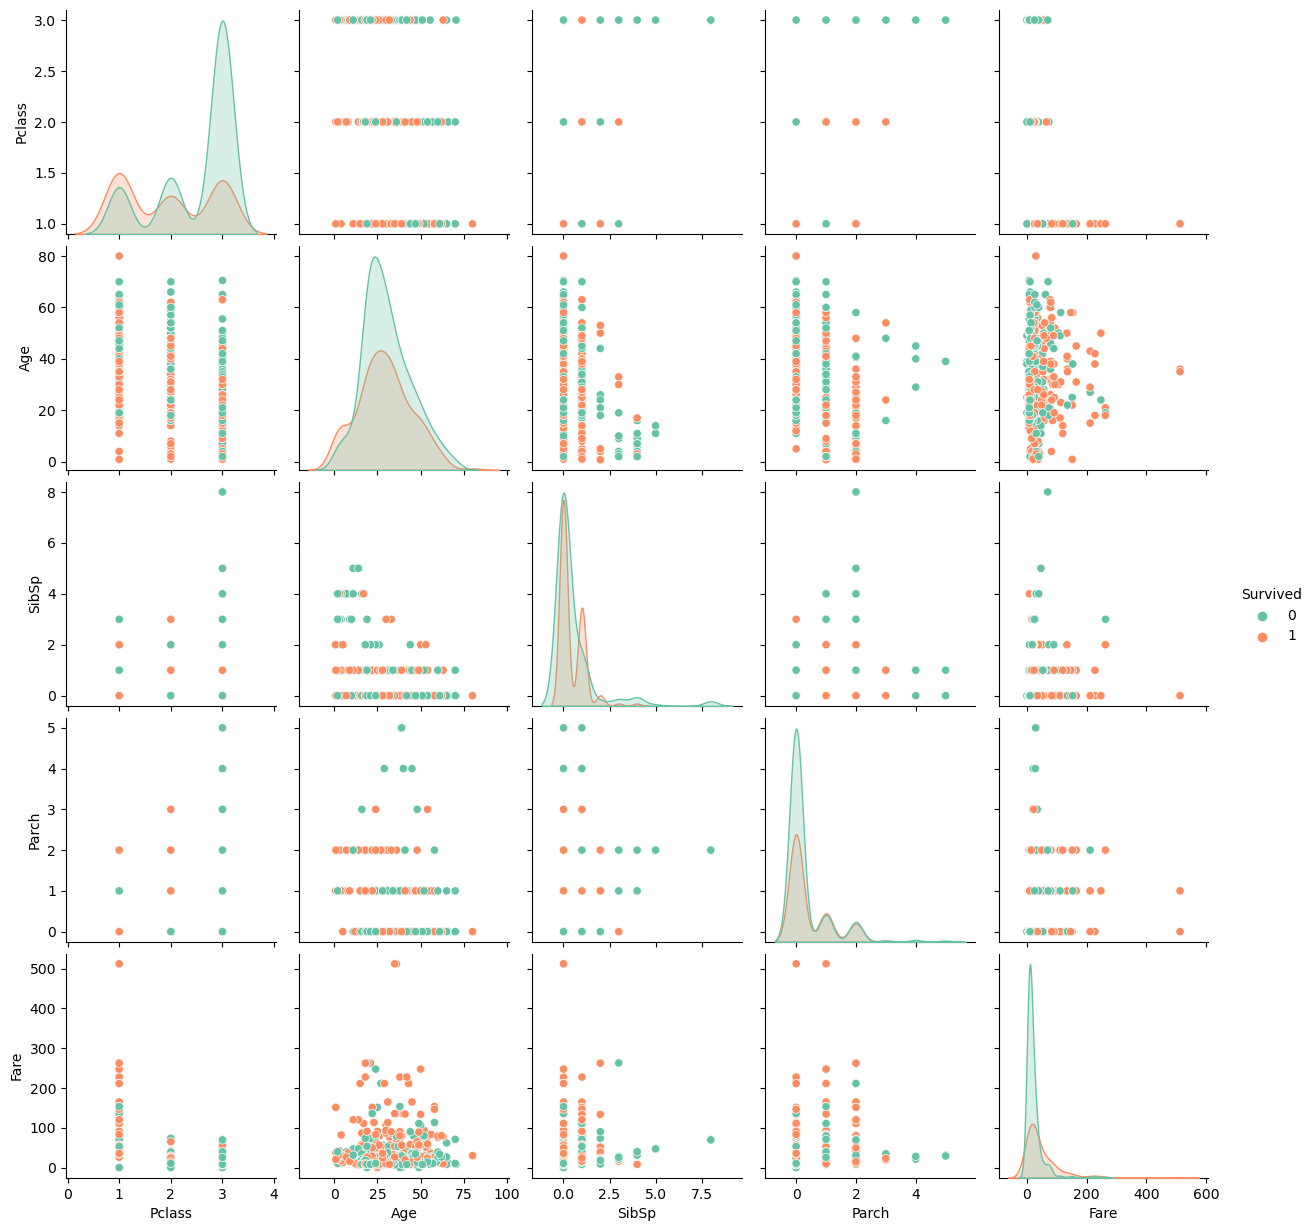

In [37]:
sns.pairplot(df, hue = 'Survived', palette = 'Set2')

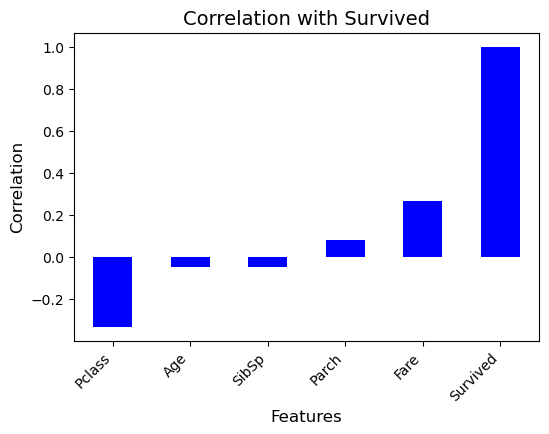

In [38]:
plt.figure(figsize=(6,4))
df.corr()['Survived'].sort_values().plot(kind='bar', color='blue')
plt.title('Correlation with Survived', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

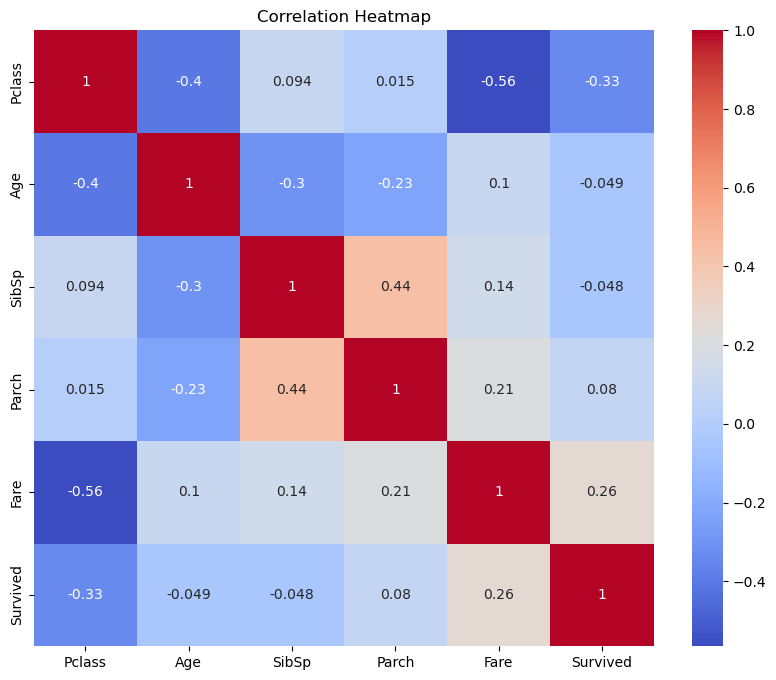

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

 it is important to conduct further analysis and consider other factors before making definitive statements about the relationship between fare and survival.

## Data Preparation

### Embarked

Converting the categorical colunm 'Embarked' into numerical data  by creating a binary indicator.

In [40]:
dummies = pd.get_dummies(df['Embarked'])
prosess_df = pd.concat([df, dummies], axis=1)

In [41]:
prosess_df = prosess_df.drop(['Embarked'], axis=1)

### Pclass

Converting the categorical colunm 'Pclass' into numerical data  by creating a binary indicator. We made this decision because we believed that the numerical values assigned to the classes might skew the model's performance.

In [42]:
dummies = pd.get_dummies(prosess_df['Pclass'],prefix='Pclass')
prosess_df = pd.concat([prosess_df, dummies], axis=1)

In [43]:
prosess_df = prosess_df.drop(['Pclass'], axis=1)

In [44]:
prosess_df

,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Survived,C,Q,S,Pclass_1,Pclass_2,Pclass_3
0,"Hart, Mr. Benjamin",male,43.0,1,1,26.2500,NaN,0,0,0,1,0,1,0
1,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,13.0000,D,1,0,0,1,0,1,0
2,"Laleff, Mr. Kristo",male,NaN,0,0,7.8958,NaN,0,0,0,1,0,0,1
3,"Naidenoff, Mr. Penko",male,22.0,0,0,7.8958,NaN,0,0,0,1,0,0,1
4,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,20.2500,NaN,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,7.7500,NaN,1,0,1,0,0,0,1
708,"Cann, Mr. Ernest Charles",male,21.0,0,0,8.0500,NaN,0,0,0,1,0,0,1
709,"Lefebre, Miss. Mathilde",female,NaN,3,1,25.4667,NaN,0,0,0,1,0,0,1
710,"Hays, Miss. Margaret Bechstein",female,24.0,0,0,83.1583,C54,1,1,0,0,1,0,0


### Sex

Converting the 'Sex' colunm to binary so the model can process  it.

In [45]:
prosess_df['Sex'] = prosess_df['Sex'].replace({'female': 1, 'male': 0})

### Name

We hypothesized that the name title might be a relevant factor for our model and thus created a list to identify the different titles present in the dataset and their frequency of occurrence. We observed that the majority of passengers had the titles of Mr, Miss, Mrs, and Master, with Mr and Miss being the most prevalent.
As we already had a 'sex' column in the dataset, we concluded that it would not be necessary to include separate 'Mr' and 'Miss' columns. We also considered adding a binary 'STAFF/PASSENGER' column, but due to the insufficiency of data regarding staff, we thought it is unnecessary.
Ultimately, we decided to drop the 'Name' column from the dataset since it did not appear to have significant predictive value for our model.





In [46]:
df_try=df.copy()
df_try['Title'] = df_try['Name']
df_try['Title'] = df_try['Title'].str.split(',').str[1]
df_try['Title'] = df_try['Title'].str.split('.').str[0]
title_occurences = df_try.groupby(by='Title').size().sort_values(ascending=False)
print(title_occurences)

Title
 Mr              419
 Miss            142
 Mrs              93
 Master           32
 Dr                6
 Rev               6
 Major             2
 Col               2
 Mlle              2
 Sir               1
 Ms                1
 Capt              1
 Mme               1
 Lady              1
 Jonkheer          1
 Don               1
 the Countess      1
dtype: int64


In [47]:
prosess_df = prosess_df.drop(['Name'], axis=1)

### Cabin

We considered adding a 'floor' column to the dataset based on the cabin column, but we discovered that nearly 80% of the data was missing, we ultimately decided to drop the cabin column from the dataset.

In [48]:
prosess_df = prosess_df.drop(['Cabin'], axis=1)

### Fare- Transforming Skewed Continuous Features

We analyzed the distribution of ticket fares and found that it was skewed. To prevent the very large and very small values from adversely affecting the performance of our learning algorithm, we decided to apply a logarithmic transformation to the data.

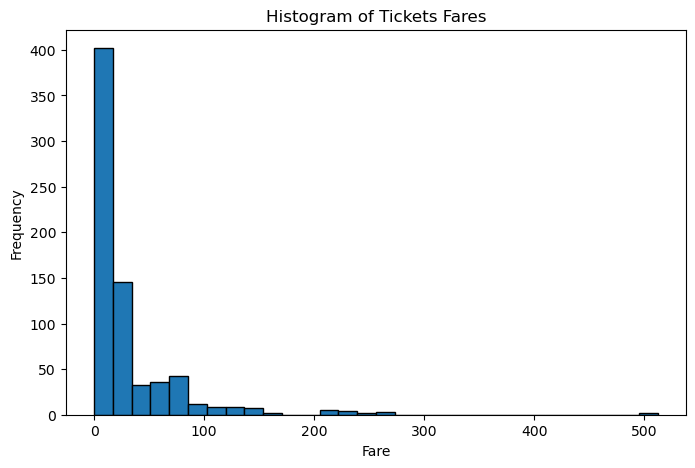

In [49]:
plt.hist(df['Fare'], bins=30, edgecolor='black')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Tickets Fares')
plt.show()

In [50]:
prosess_df['Fare'] = prosess_df['Fare'].apply(lambda x: np.log(x + 1))

The distribution of 'Tickets Fare' after the logtirmic transformation

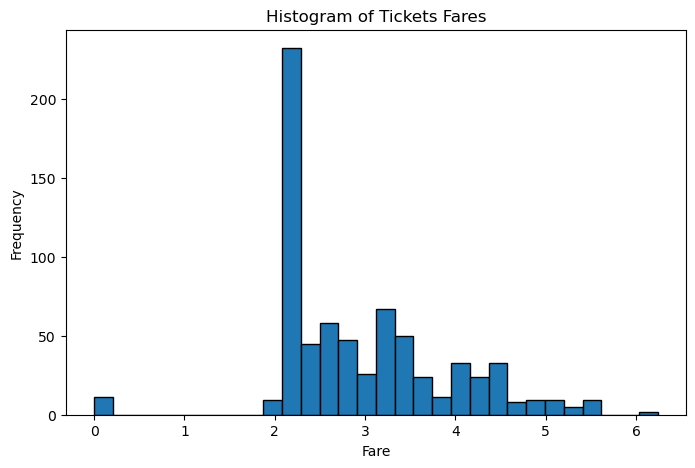

In [51]:
plt.hist(prosess_df['Fare'], bins=30, edgecolor='black')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Tickets Fares')
plt.show()

## Finding Outliers

First, we will use a boxplot to observe outliers in the 'fare' variable, as it is a continuous variable and may still have outliers despite the log transformation we performed. We did not check for outliers in the 'age' variable due to its high number of missing values.

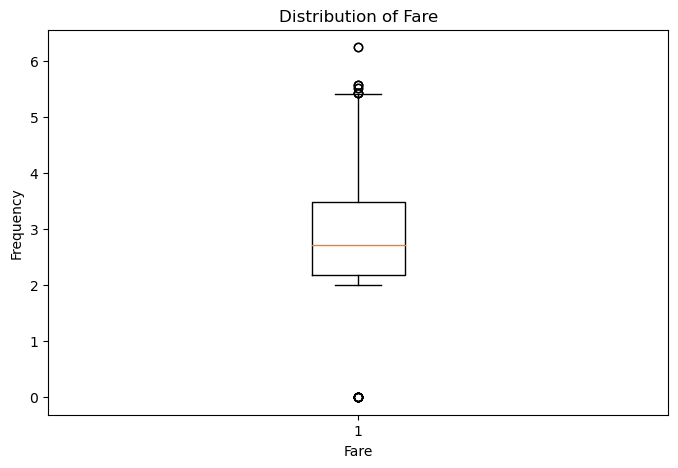

In [52]:
fig, ax = plt.subplots()
ax.boxplot(prosess_df['Fare'])
ax.set_title('Distribution of Fare')
ax.set_xlabel('Fare')
ax.set_ylabel('Frequency')
plt.show()

We want to check the number of outliers to see if we can erase them.

In [53]:
q1 = prosess_df['Fare'].quantile(0.25)
q3 = prosess_df['Fare'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5*iqr
lower_bound = q1 - 1.5*iqr
num_outliers = prosess_df[(prosess_df['Fare'] > upper_bound) | (prosess_df['Fare'] < lower_bound)].shape[0]
print(f"Number of outliers in 'Fare': {num_outliers}")


Number of outliers in 'Fare': 22


Given the small number of outliers in our data, we have decided that the most appropriate approach is to remove them.

In [54]:
prosess_df = prosess_df[(prosess_df['Fare'] >= lower_bound) & (prosess_df['Fare'] <= upper_bound)]


## Models Summary Function

In [55]:
models_summery_fun={'Model_type': [],
                'Scaler_method': [],
                'Age_method': [],
                'features': [],
                'hyper_parameters': [],
                'F1_score': []}

def update_models_summery(Modeltype,Scalermethod,Agemethod,feat,hyperparameters,F1):
    models_summery_fun['Model_type'].append(Modeltype)
    models_summery_fun['Scaler_method'].append(Scalermethod)
    models_summery_fun['Age_method'].append(Agemethod)
    models_summery_fun['features'].append(feat)
    models_summery_fun['hyper_parameters'].append(hyperparameters)
    models_summery_fun['F1_score'].append(F1)

## Age- Method 1

To impute the missing values in the 'Age' column, we attempted two methods. In the first method, we replaced the missing values with the median value of the same category of instances, determined by the values in the 'SibSp' and 'Parch' columns. We believed that these columns would be the best indicators of age. If we could not find a suitable match, we chose to drop those instances from the dataset (7 in total). Now, we will examine the results of this imputation method.

In [56]:
df_clean=prosess_df.copy()
result=df_clean[df_clean['Age'].isna()][['SibSp', 'Parch']]
result=result.drop_duplicates()
result=result.values
df_with_na=df_clean[df_clean['Age'].isna()]
df_without_na= df_clean[df_clean['Age'].notna()]               
for i in result:
    a=df_without_na[(df_without_na['SibSp'] == i[0]) & (df_without_na['Parch'] == i[1])]
    median_age=a['Age'].median()
    df_with_na.loc[(df_with_na['SibSp'] == i[0]) & (df_with_na['Parch'] == i[1]), 'Age'] = median_age
    
df_with_na = df_with_na.dropna(subset=['Age'])
df_clean = pd.concat([df_with_na, df_without_na], ignore_index=True)

In [57]:
print("you have",df_clean.isnull().sum().sum(),"missing values on the data")

you have 0 missing values on the data


## Implementing Basic Models

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X = df_clean.drop(columns=['Survived']).values
y = df_clean['Survived'].values

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [61]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

### Knn- with the first method to deal with missing values on age featurs and with min max scaler

Initially, we attempted to determine the optimal combination of K and distance metric for a given dataset. We accomplished this by implementing KNN with varying K values and distance metrics. Afterward, we evaluated the resulting models using the F1 score.

In [62]:
from sklearn.metrics import confusion_matrix

F1={}
accuracy={}
precision={}
recall={}
for k in range(5,20):
    for method in range(1,3):
        knn = KNeighborsClassifier(n_neighbors=k, p=method)
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_val)
        
        knn_confusion_matrix = confusion_matrix(y_val, y_predict)
        
        TP = knn_confusion_matrix[0,0]
        FN = knn_confusion_matrix[0,1]
        FP = knn_confusion_matrix[1,0]
        TN = knn_confusion_matrix[1,1]
        
        if (method==1):
            method_str="Manhattan" 
        else:
            method_str="Euclidean"
        
        print("number of k", k, "the method is: ", method_str)
        
        if (TP + FP)==0 or (TP + FN)==0:
            F1=-1
            knn_precision=-1
            knn_recall=-1
        else:
            knn_precision = TP / (TP + FP)
            knn_recall = TP / (TP + FN)
            knn_F1 = 2* (knn_precision*knn_recall) / (knn_precision + knn_recall)
        
        knn_accuracy = (TP + TN) / (FN + FP + TP + TN)
        print("Accuracy=", knn_accuracy)
        accuracy[k,method_str]=knn_accuracy
        
        print("Precision=", knn_precision)
        precision[k,method_str]=knn_precision

        print("Recall=", knn_recall)
        recall[k,method_str]=knn_recall
        F1[k,method_str]=knn_F1
        
        print("F1 score=", knn_F1)
        print("---------------------------------------")
        
best_k,best_method = max(F1, key=F1.get)


number of k 5 the method is:  Manhattan
Accuracy= 0.7664233576642335
Precision= 0.76
Recall= 0.9047619047619048
F1 score= 0.8260869565217391
---------------------------------------
number of k 5 the method is:  Euclidean
Accuracy= 0.781021897810219
Precision= 0.7755102040816326
Recall= 0.9047619047619048
F1 score= 0.8351648351648353
---------------------------------------
number of k 6 the method is:  Manhattan
Accuracy= 0.7737226277372263
Precision= 0.7623762376237624
Recall= 0.9166666666666666
F1 score= 0.8324324324324324
---------------------------------------
number of k 6 the method is:  Euclidean
Accuracy= 0.7956204379562044
Precision= 0.78
Recall= 0.9285714285714286
F1 score= 0.8478260869565217
---------------------------------------
number of k 7 the method is:  Manhattan
Accuracy= 0.7518248175182481
Precision= 0.7604166666666666
Recall= 0.8690476190476191
F1 score= 0.8111111111111111
---------------------------------------
number of k 7 the method is:  Euclidean
Accuracy= 0.78

We are wondering which model evaluation metric to use, you can see that Accuracy is generally smaller than the f1 score and also Precision is generally smaller than recall.
We suspect that the reason could be unbalanced classes or the distribution of the data is unbalanced between the val and training arrays

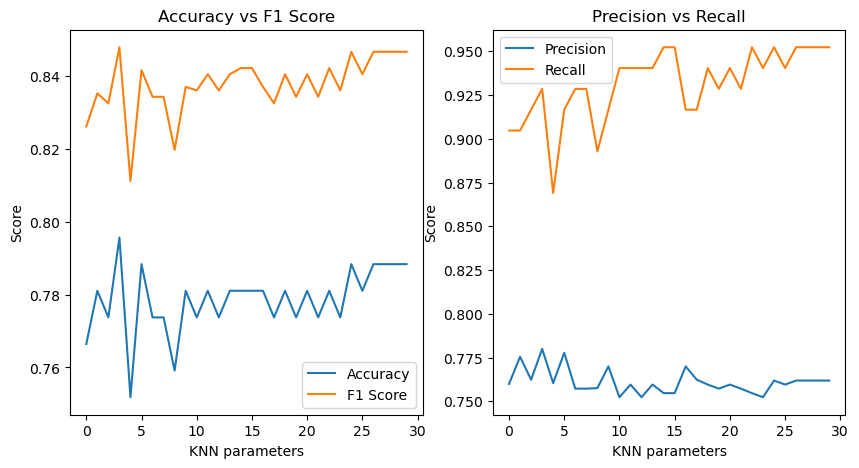

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(list(accuracy.values()), label='Accuracy')
ax[0].plot(list(F1.values()), label='F1 Score')
ax[0].set_xlabel('KNN parameters')
ax[0].set_ylabel('Score')
ax[0].set_title('Accuracy vs F1 Score')
ax[0].legend()

ax[1].plot(list(precision.values()), label='Precision')
ax[1].plot(list(recall.values()), label='Recall')
ax[1].set_xlabel('KNN parameters')
ax[1].set_ylabel('Score')
ax[1].set_title('Precision vs Recall')
ax[1].legend()

plt.show()


Let's check it with Logistic Regression 
## Logistic Regression 

In [64]:
from sklearn.metrics import f1_score
import itertools
from sklearn.metrics import confusion_matrix

etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

F1={}
accuracy={}
precision={}
recall={}

combinations= list(itertools.product(etas,epss))

for couples in combinations:
    eta=couples[0]
    eps=couples[1]
    LG = LogisticRegressionGD(eta=eta,eps=eps)
    LG.fit(X_train, y_train)
    y_pred = LG.predict(X_val)
    
    LG_confusion_matrix = confusion_matrix(y_val, y_pred)
        
    TP = LG_confusion_matrix[0,0]
    FN = LG_confusion_matrix[0,1]
    FP = LG_confusion_matrix[1,0]
    TN = LG_confusion_matrix[1,1]
    
    if (TP + FP)==0 or (TP + FN)==0:
        pass
    else:
        LG_precision = TP / (TP + FP)
        LG_recall = TP / (TP + FN)
        LG_F1 = 2* (LG_precision*LG_recall) / (LG_precision + LG_recall)
    
        print("the value of eta is:", eta, "the value of eta is:", eps)

        LG_accuracy = (TP + TN) / (FN + FP + TP + TN)
        print("Accuracy=", LG_accuracy)
        accuracy[eta,eps]=LG_accuracy
        
        print("Precision=", LG_precision)
        precision[eta,eps]=LG_precision

        print("Recall=", LG_recall)
        recall[eta,eps]=LG_recall
    
        F1[eta,eps]=LG_F1
        print("F1 score=", LG_F1)
    
        print("---------------------------------------")
    
best_eta,best_eps = max(F1, key=F1.get)


the value of eta is: 0.05 the value of eta is: 0.01
Accuracy= 0.6788321167883211
Precision= 0.6587301587301587
Recall= 0.9880952380952381
F1 score= 0.7904761904761906
---------------------------------------
the value of eta is: 0.05 the value of eta is: 0.001
Accuracy= 0.6715328467153284
Precision= 0.8
Recall= 0.6190476190476191
F1 score= 0.697986577181208
---------------------------------------
the value of eta is: 0.05 the value of eta is: 0.0001
Accuracy= 0.7372262773722628
Precision= 0.7142857142857143
Recall= 0.9523809523809523
F1 score= 0.8163265306122449
---------------------------------------
the value of eta is: 0.05 the value of eta is: 1e-05
Accuracy= 0.7445255474452555
Precision= 0.788235294117647
Recall= 0.7976190476190477
F1 score= 0.7928994082840236
---------------------------------------
the value of eta is: 0.05 the value of eta is: 1e-06
Accuracy= 0.7445255474452555
Precision= 0.7692307692307693
Recall= 0.8333333333333334
F1 score= 0.8
--------------------------------

Now you can see that the accuracy is still smaller (to a lesser extent) than f1 and it also seems that the Precision is generally smaller than recall but to a much lesser extent than of the knn.
The reasons we thought of are that as we know Logistic Regression is less sensitive to imbalanced data than KNN and maybe to the fact that logistic regression puts weights on each feature can help it deal with the curse of dimensionality better than KNN.

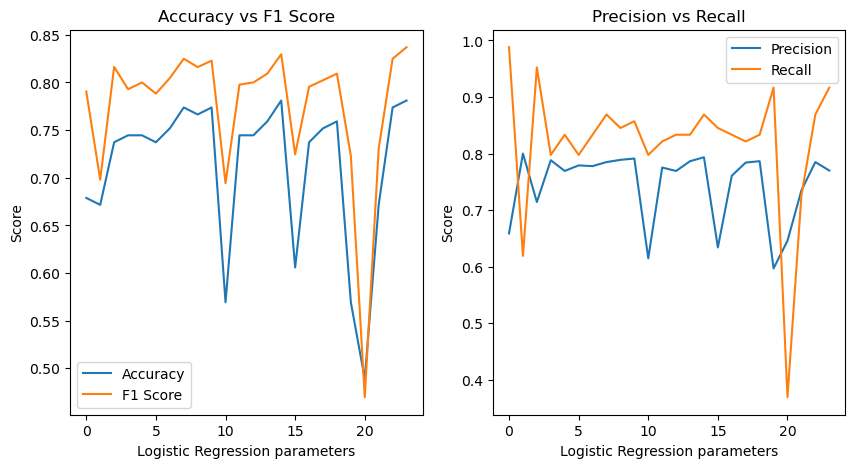

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(list(accuracy.values()), label='Accuracy')
ax[0].plot(list(F1.values()), label='F1 Score')
ax[0].set_xlabel('Logistic Regression parameters')
ax[0].set_ylabel('Score')
ax[0].set_title('Accuracy vs F1 Score')
ax[0].legend()

ax[1].plot(list(precision.values()), label='Precision')
ax[1].plot(list(recall.values()), label='Recall')
ax[1].set_xlabel('Logistic Regression parameters')
ax[1].set_ylabel('Score')
ax[1].set_title('Precision vs Recall')
ax[1].legend()

plt.show()


##### lets check the proportion between the lables of the target values

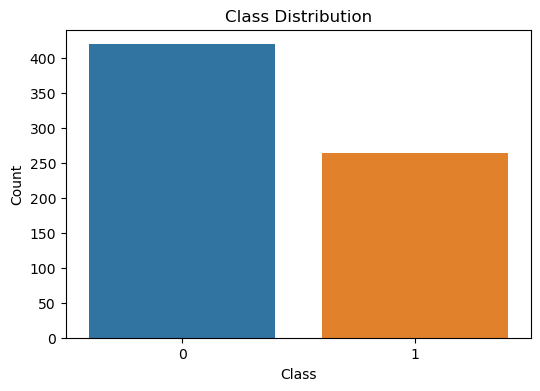

We have 264 people who survived and 419 people who didn't survived


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = df_clean['Survived'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


print("We have", counts[1], "people who survived and", counts[0] ,"people who didn't survived")


״In general, precision tends to be smaller than recall when the positive class is rare, as false positives are penalized more heavily than false negatives.״

Our target variable is indeed unbalanced (almost twice did not survive compared to those who did), **so we will use the f1 score to evaluate the model in a better way** when the data is indeed unbalanced and in addition **we will use the k-fold method to avoid an unequal distribution of x val and x train**.
Also we learned about the **importance of features selection** (especially in knn) in the following steps we will apply all these insights.

# Experiment Different Models

To find the optimal model, we aim to identify the hyperparameters that yield the highest score, using the k-fold method as previously mentioned. Initially, we attempted to search for optimal values for each hyperparameter separately. However, we realized that an efficient approach would be to write a code that would go through all the possible combinations of the features, distance metrics (p=2, p=1), and the k values we defined and in logistic regression accordingly. This feature selection helps us deal with the curse of dimensionality. However, the execution time for such an approach is very slow. Hence, for this task, we randomly selected 500 of these options to reduce the computational load.
In the following steps, we will write the general code and apply it later each time with a different method (a method for completing missing values, a normalization method, etc.). In each code we will choose the best model for those methods and gather everything in a summary table.

In [67]:
X = df_clean.drop(columns=['Survived']).values
y = df_clean['Survived'].values

### knn- with the first method to deal with missing values on age featurs and with min max scaler

As we plan to make changes in the data preprocessing method for handling missing values in the 'Age' column, such as adding or removing columns, we have decided to define the following code as a function. This will make it easier to apply the same preprocessing steps to both the training and validation sets.

In [68]:
from itertools import combinations, product
def Knn_MinMax_Model(X,y):
    scaler = MinMaxScaler()

    # Define the range of k values
    k_range = range(5, 14, 2)

    # Define the list of features
    feature_indices = range(X.shape[1])

    # Generate all combinations of features
    feature_combinations = []
    for num_features in range(3, len(feature_indices) + 1):
        feature_combinations += combinations(feature_indices, num_features)

    # Generate all combinations of k, feature subsets, and p
    k_feature_p_combinations = list(product(k_range, feature_combinations, [1, 2]))

    # Randomly select 500 combinations
    k_feature_p_combinations = random.sample(k_feature_p_combinations, 1000)

    dic = {}
    for com in k_feature_p_combinations:
        dic[com] = 0

    for com in k_feature_p_combinations:
        k, feat, p = com
        for fold in range(5): 
            rel_X = X[:, list(feat)]
            indices = np.random.permutation(rel_X.shape[0])
            idx_train, idx_val = indices[:int(0.8*rel_X.shape[0])], indices[int(0.8*rel_X.shape[0]):]
            X_train, X_val = rel_X[idx_train], rel_X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = KNeighborsClassifier(k)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1_score=f1_score(y_val, y_pred, average = 'weighted')
            dic[com]+=F1_score

    for comp in k_feature_p_combinations:
        dic[comp]/=5
    
    best_k, best_fet, best_p=max(dic,key=dic.get)
    return best_k, best_fet, best_p,dic

In [69]:
best_k, best_fet, best_p,dic=Knn_MinMax_Model(X,y)

In [70]:
string_features = []
for feature in best_fet:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('SibSp')
    elif feature == 3:
        string_features.append('Parch')
    elif feature == 4:
        string_features.append('Fare')
    elif feature == 5:
        string_features.append('C')
    elif feature == 6:
        string_features.append('Q')
    elif feature == 7:
        string_features.append('S')
    elif feature == 8:
        string_features.append('Pclass_1')
    elif feature == 9:
        string_features.append('Pclass_2')
    elif feature == 10:
        string_features.append('Pclass_3')

f1_of_best=dic[max(dic,key=dic.get)]
print("the best k is:",best_k,"the best p is:",best_p, "the best features is:", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best k is: 7 the best p is: 2 the best features is: Sex, Age, SibSp, Parch, Fare
f1 score is:  0.833691635352024


In [71]:
update_models_summery(Modeltype='Knn',Scalermethod='Min_Max',Agemethod=1,feat=string_features,hyperparameters={'k':best_k,'p':best_p},F1=f1_of_best)

### knn- with the first method to deal with missing values on age featurs and with Standard Scaler

Now we will try it with Standard Scaler

In [72]:
def Knn_Standard_Model(X,y):

    scaler = StandardScaler()

    # Define the range of k values
    k_range = range(5, 14, 2)

    # Define the list of features
    feature_indices = range(X.shape[1])

    # Generate all combinations of features
    feature_combinations = []
    for num_features in range(3, len(feature_indices) + 1):
        feature_combinations += combinations(feature_indices, num_features)

    # Generate all combinations of k, feature subsets, and p
    k_feature_p_combinations = list(product(k_range, feature_combinations, [1, 2]))

    # Randomly select 500 combinations
    k_feature_p_combinations = random.sample(k_feature_p_combinations, 1000)

    # Initialize dictionary to store results
    dic = {}
    for com in k_feature_p_combinations:
        dic[com] = 0


    for com in k_feature_p_combinations:
        k, feat, p = com
        for fold in range(5): 
            rel_X = X[:, list(feat)]
            indices = np.random.permutation(rel_X.shape[0])
            idx_train, idx_val = indices[:int(0.8*rel_X.shape[0])], indices[int(0.8*rel_X.shape[0]):]
            X_train, X_val = rel_X[idx_train], rel_X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = KNeighborsClassifier(k)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1_score=f1_score(y_val, y_pred, average = 'weighted')
            dic[com]+=F1_score

    for comp in k_feature_p_combinations:
        dic[comp]/=5
    
    best_k, best_fet, best_p=max(dic,key=dic.get) 
    return best_k, best_fet, best_p,dic

In [73]:
best_k, best_fet, best_p,dic=Knn_Standard_Model(X,y)

In [74]:
string_features = []
for feature in best_fet:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('SibSp')
    elif feature == 3:
        string_features.append('Parch')
    elif feature == 4:
        string_features.append('Fare')
    elif feature == 5:
        string_features.append('C')
    elif feature == 6:
        string_features.append('Q')
    elif feature == 7:
        string_features.append('S')
    elif feature == 8:
        string_features.append('Pclass_1')
    elif feature == 9:
        string_features.append('Pclass_2')
    elif feature == 10:
        string_features.append('Pclass_3')
        
f1_of_best=dic[max(dic,key=dic.get)]

In [75]:
print("the best k is: ",best_k,"the best p is: ",best_p, "the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best k is:  9 the best p is:  2 the best features is:  Sex, SibSp, Parch, Fare, Q, S, Pclass_1, Pclass_2, Pclass_3
f1 score is:  0.8288066597247804


In [76]:
update_models_summery(Modeltype='Knn',Scalermethod='Standard',Agemethod=1,feat=string_features,hyperparameters={'k':best_k,'p':best_p},F1=f1_of_best)

### Logistic Regression with the first method to deal with missing values on age featurs and with min max scaler

To find the hyperparameters that would give us the best model, we decided to explore various combinations of eta, epsilon, and the number of iterations, as well as all possible feature combinations to handle the curse of dimensionality. However, since running all possible combinations would be very time-consuming, we randomly selected 500 combinations for this work. We will also be using k-folds to ensure that our model is evaluated on a balanced distribution of data.

In [77]:
def LogisticRegression_MinMax_Model(X,y):

    scaler = MinMaxScaler()

    # Define the list of features
    feature_indices = range(X.shape[1])

    # Generate all combinations of features
    feature_combinations = []
    for num_features in range(3, len(feature_indices) + 1):
        feature_combinations += combinations(feature_indices, num_features)

    # Define the range of n_iter values
    n_iter_range = [1000, 2000, 5000]

    # Define the list of etas and epss
    etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
    epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

    # Generate all combinations of etas, feature subsets, epss, and n_iter
    etas_feature_epss_n_iter_combinations = list(itertools.product(etas, feature_combinations, epss, n_iter_range))

    # Randomly select 500 combinations
    etas_feature_epss_n_iter_combinations = random.sample(etas_feature_epss_n_iter_combinations, 500)


    dic = {}
    for com in etas_feature_epss_n_iter_combinations:
        dic[com] = 0

    for com in etas_feature_epss_n_iter_combinations:
        eta, feat, eps, n_iter = com
        for fold in range(5): 
            rel_X = X[:, list(feat)]
            indices = np.random.permutation(rel_X.shape[0])
            idx_train, idx_val = indices[:int(0.8*rel_X.shape[0])], indices[int(0.8*rel_X.shape[0]):]
            X_train, X_val = rel_X[idx_train], rel_X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = LogisticRegressionGD(eta=eta,eps=eps,n_iter=n_iter)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1_score=f1_score(y_val, y_pred, average = 'weighted')
            dic[com]+=F1_score

    for comp in etas_feature_epss_n_iter_combinations:
        dic[comp]/=5

    best_eta, best_feat, best_eps, best_n_iter=max(dic,key=dic.get) 
    return best_eta, best_feat, best_eps, best_n_iter, dic


In [78]:
best_eta, best_feat, best_eps, best_n_iter, dic=LogisticRegression_MinMax_Model(X,y)

In [79]:
string_features = []
for feature in best_fet:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('SibSp')
    elif feature == 3:
        string_features.append('Parch')
    elif feature == 4:
        string_features.append('Fare')
    elif feature == 5:
        string_features.append('C')
    elif feature == 6:
        string_features.append('Q')
    elif feature == 7:
        string_features.append('S')
    elif feature == 8:
        string_features.append('Pclass_1')
    elif feature == 9:
        string_features.append('Pclass_2')
    elif feature == 10:
        string_features.append('Pclass_3')
        
f1_of_best=dic[max(dic,key=dic.get)]

In [80]:
print("the best eta is: ",best_eta,"the best eps is: ",best_eps,"the best number of iteration is: ",best_n_iter,"the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best eta is:  0.0005 the best eps is:  1e-06 the best number of iteration is:  2000 the best features is:  Sex, SibSp, Parch, Fare, Q, S, Pclass_1, Pclass_2, Pclass_3
f1 score is:  0.806339513742126


In [81]:
update_models_summery(Modeltype='Logistic_Regression',Scalermethod='Min_Max',Agemethod=1,feat=string_features,hyperparameters={'eta':best_eta,'eps':best_eps,'n_iter':best_n_iter},F1=f1_of_best)

### Logistic Regression with the first method to deal with missing values on age featurs and with Standard Scaler

Now we will do it with standard scaler

In [82]:
def LogisticRegression_Standard_Model(X,y):

    scaler = StandardScaler()

    # Define the list of features
    feature_indices = range(X.shape[1])

    # Generate all combinations of features
    feature_combinations = []
    for num_features in range(3, len(feature_indices) + 1):
        feature_combinations += combinations(feature_indices, num_features)

    # Define the range of n_iter values
    n_iter_range = [1000, 2000, 5000]

    # Define the list of etas and epss
    etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
    epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

    # Generate all combinations of etas, feature subsets, epss, and n_iter
    etas_feature_epss_n_iter_combinations = list(itertools.product(etas, feature_combinations, epss, n_iter_range))

    # Randomly select 500 combinations
    etas_feature_epss_n_iter_combinations = random.sample(etas_feature_epss_n_iter_combinations, 500)


    dic = {}
    for com in etas_feature_epss_n_iter_combinations:
        dic[com] = 0

    for com in etas_feature_epss_n_iter_combinations:
        eta, feat, eps, n_iter = com
        for fold in range(5): 
            rel_X = X[:, list(feat)]
            indices = np.random.permutation(rel_X.shape[0])
            idx_train, idx_val = indices[:int(0.8*rel_X.shape[0])], indices[int(0.8*rel_X.shape[0]):]
            X_train, X_val = rel_X[idx_train], rel_X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = LogisticRegressionGD(eta=eta,eps=eps,n_iter=n_iter)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1_score=f1_score(y_val, y_pred, average = 'weighted')
            dic[com]+=F1_score

    for comp in etas_feature_epss_n_iter_combinations:
        dic[comp]/=5

    best_eta, best_feat, best_eps, best_n_iter=max(dic,key=dic.get) 
    return best_eta, best_feat, best_eps, best_n_iter, dic

In [83]:
best_eta, best_feat, best_eps, best_n_iter, dic=LogisticRegression_Standard_Model(X,y)

In [84]:
string_features = []
for feature in best_fet:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('SibSp')
    elif feature == 3:
        string_features.append('Parch')
    elif feature == 4:
        string_features.append('Fare')
    elif feature == 5:
        string_features.append('C')
    elif feature == 6:
        string_features.append('Q')
    elif feature == 7:
        string_features.append('S')
    elif feature == 8:
        string_features.append('Pclass_1')
    elif feature == 9:
        string_features.append('Pclass_2')
    elif feature == 10:
        string_features.append('Pclass_3')
f1_of_best=dic[max(dic,key=dic.get)]

In [85]:
print("the best eta is: ",best_eta,"the best eps is: ",best_eps,"the best number of iteration is: ",best_n_iter,"the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best eta is:  0.005 the best eps is:  1e-06 the best number of iteration is:  2000 the best features is:  Sex, SibSp, Parch, Fare, Q, S, Pclass_1, Pclass_2, Pclass_3
f1 score is:  0.8235892660291514


In [86]:
update_models_summery(Modeltype='Logistic_Regression',Scalermethod='Standard',Agemethod=1,feat=string_features,hyperparameters={'eta':best_eta,'eps':best_eps,'n_iter':best_n_iter},F1=f1_of_best)

## Adding is_alone column still with the fisrt age missing values method

We have decided to add the column 'is alone' to the model as we believe it may provide valuable insight into any potential correlation between traveling alone and survival. After adding the column, we decided to drop the 'SibSp' and 'Parch'  columns to avoid duplicates and run the model again.

Now, let's evaluate if the F1 score has improved.

In [87]:
df_clean['Relatives_tmp'] = df_clean['SibSp'] + df_clean['Parch']
df_clean.loc[df_clean['Relatives_tmp'] > 0, 'is_alone'] = 0
df_clean.loc[df_clean['Relatives_tmp'] == 0, 'is_alone'] = 1
df_clean['is_alone'] = df_clean['is_alone'].astype(int)
df_clean = df_clean.drop(['Relatives_tmp'], axis=1)

In [88]:
df_clean

,Sex,Age,SibSp,Parch,Fare,Survived,C,Q,S,Pclass_1,Pclass_2,Pclass_3,is_alone
0,0,29.0,0,0,2.185579,0,0,0,1,0,0,1,1
1,0,29.0,0,0,2.351375,0,0,0,1,0,0,1,1
2,0,29.0,0,0,2.171907,1,0,0,1,0,0,1,1
3,0,29.0,0,0,2.202765,0,0,0,1,0,0,1,1
4,0,29.0,0,0,2.107178,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0,28.0,0,0,3.597312,1,0,0,1,1,0,0,1
679,0,19.0,0,0,2.202765,0,0,0,1,0,0,1,1
680,0,21.0,0,0,2.202765,0,0,0,1,0,0,1,1
681,1,24.0,0,0,4.432700,1,1,0,0,1,0,0,1


In [89]:
X = df_clean.drop(columns=['SibSp','Parch','Survived']).values
y = df_clean['Survived'].values

### Knn with the first method to deal with missing values on age featurs and with Min Max Scaler and with is_alone column

In [90]:
best_k, best_fet, best_p,dic=Knn_MinMax_Model(X,y)

In [91]:
string_features = []
for feature in best_feat:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('Fare')
    elif feature == 3:
        string_features.append('C')
    elif feature == 4:
        string_features.append('Q')
    elif feature == 5:
        string_features.append('S')
    elif feature == 6:
        string_features.append('Pclass_1')
    elif feature == 7:
        string_features.append('Pclass_2')
    elif feature == 8:
        string_features.append('Pclass_3')
    elif feature == 9:
        string_features.append('is_alone')
f1_of_best=dic[max(dic,key=dic.get)]

In [92]:
print("the best k is: ",best_k,"the best p is: ",best_p, "the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best k is:  5 the best p is:  2 the best features is:  Sex, Age, S, Pclass_1, is_alone
f1 score is:  0.8321575074760681


In [93]:
update_models_summery(Modeltype='Knn',Scalermethod='Min_Max',Agemethod=1,feat=string_features,hyperparameters={'k':best_k,'p':best_p},F1=f1_of_best)

### Knn with the first method to deal with missing values on age featurs and with Standard Scaler and with is_alone column

In [94]:
best_k, best_fet, best_p,dic=Knn_Standard_Model(X,y) 

In [95]:
string_features = []
for feature in best_feat:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('Fare')
    elif feature == 3:
        string_features.append('C')
    elif feature == 4:
        string_features.append('Q')
    elif feature == 5:
        string_features.append('S')
    elif feature == 6:
        string_features.append('Pclass_1')
    elif feature == 7:
        string_features.append('Pclass_2')
    elif feature == 8:
        string_features.append('Pclass_3')
    elif feature == 9:
        string_features.append('is_alone')
f1_of_best=dic[max(dic,key=dic.get)]

In [96]:
print("the best k is: ",best_k,"the best p is: ",best_p, "the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best k is:  5 the best p is:  2 the best features is:  Sex, Age, S, Pclass_1, is_alone
f1 score is:  0.8328026363860543


In [97]:
update_models_summery(Modeltype='Knn',Scalermethod='Standard',Agemethod=1,feat=string_features,hyperparameters={'k':best_k,'p':best_p},F1=f1_of_best)

### Logistic Regression with the first method to deal with missing values on age featurs and with Min Max Scaler and with is_alone column

In [98]:
best_eta, best_feat, best_eps, best_n_iter, dic=LogisticRegression_MinMax_Model(X,y) 

In [99]:
string_features = []
for feature in best_feat:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('Fare')
    elif feature == 3:
        string_features.append('C')
    elif feature == 4:
        string_features.append('Q')
    elif feature == 5:
        string_features.append('S')
    elif feature == 6:
        string_features.append('Pclass_1')
    elif feature == 7:
        string_features.append('Pclass_2')
    elif feature == 8:
        string_features.append('Pclass_3')
    elif feature == 9:
        string_features.append('is_alone')
        
f1_of_best=dic[max(dic,key=dic.get)]

In [100]:
print("the best eta is: ",best_eta,"the best eps is: ",best_eps,"the best number of iteration is: ",best_n_iter,"the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best eta is:  0.005 the best eps is:  1e-05 the best number of iteration is:  5000 the best features is:  Sex, Age, Q, S, Pclass_2, is_alone
f1 score is:  0.8167554731774619


In [101]:
update_models_summery(Modeltype='Logistic_Regression',Scalermethod='Min_Max',Agemethod=1,feat=string_features,hyperparameters={'eta':best_eta,'eps':best_eps,'n_iter':best_n_iter},F1=f1_of_best)

### Logistic Regression with the first method to deal with missing values on age featurs and with Standard Scaler and with is_alone column

In [102]:
best_eta, best_feat, best_eps, best_n_iter, dic=LogisticRegression_Standard_Model(X,y)

In [103]:
string_features = []
for feature in best_feat:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('Fare')
    elif feature == 3:
        string_features.append('C')
    elif feature == 4:
        string_features.append('Q')
    elif feature == 5:
        string_features.append('S')
    elif feature == 6:
        string_features.append('Pclass_1')
    elif feature == 7:
        string_features.append('Pclass_2')
    elif feature == 8:
        string_features.append('Pclass_3')
    elif feature == 9:
        string_features.append('is_alone')
f1_of_best=dic[max(dic,key=dic.get)]

In [104]:
print("the best eta is: ",best_eta,"the best eps is: ",best_eps,"the best number of iteration is: ",best_n_iter,"the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best eta is:  0.005 the best eps is:  0.0001 the best number of iteration is:  1000 the best features is:  Sex, Age, C, Q, Pclass_3
f1 score is:  0.8294144836575699


In [105]:
update_models_summery(Modeltype='Logistic_Regression',Scalermethod='Standard',Agemethod=1,feat=string_features,hyperparameters={'eta':best_eta,'eps':best_eps,'n_iter':best_n_iter},F1=f1_of_best)

## Filling missing values in Age with linear regression- method 2

Now we will fill in the missing values ​​in the Age column by another method and try all the models again.

In [106]:
df_clean=prosess_df.copy()
df_without_na=df_clean.dropna()
X = df_without_na.drop(columns=['Survived'])
y = X['Age']
X = X.drop(['Age'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
X1=df_clean.drop(columns=['Survived'])
missing_age = X1[X1['Age'].isnull()].drop(['Age'], axis=1)
predicted_age = model.predict(missing_age)
df_clean.loc[df_clean['Age'].isnull(), 'Age'] = predicted_age

In [107]:
print("you have",df_clean.isnull().sum().sum(),"missing values on the data")

you have 0 missing values on the data


In [108]:
df_clean

,Sex,Age,SibSp,Parch,Fare,Survived,C,Q,S,Pclass_1,Pclass_2,Pclass_3
0,0,43.000000,1,1,3.305054,0,0,0,1,0,1,0
1,1,36.000000,0,0,2.639057,1,0,0,1,0,1,0
2,0,28.908426,0,0,2.185579,0,0,0,1,0,0,1
3,0,22.000000,0,0,2.185579,0,0,0,1,0,0,1
4,1,35.000000,1,1,3.056357,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
707,0,32.497518,0,0,2.169054,1,0,1,0,0,0,1
708,0,21.000000,0,0,2.202765,0,0,0,1,0,0,1
709,1,12.092932,3,1,3.275887,0,0,0,1,0,0,1
710,1,24.000000,0,0,4.432700,1,1,0,0,1,0,0


In [109]:
X = df_clean.drop(columns=['Survived']).values
y = df_clean['Survived'].values

### Knn with the second method to deal with missing values on age featurs and with MinMax Scaler

In [110]:
best_k, best_fet, best_p,dic=Knn_MinMax_Model(X,y)

In [111]:
string_features = []
for feature in best_fet:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('SibSp')
    elif feature == 3:
        string_features.append('Parch')
    elif feature == 4:
        string_features.append('Fare')
    elif feature == 5:
        string_features.append('C')
    elif feature == 6:
        string_features.append('Q')
    elif feature == 7:
        string_features.append('S')
    elif feature == 8:
        string_features.append('Pclass_1')
    elif feature == 9:
        string_features.append('Pclass_2')
    elif feature == 10:
        string_features.append('Pclass_3')
f1_of_best=dic[max(dic,key=dic.get)]

In [112]:
print("the best k is: ",best_k,"the best p is: ",best_p, "the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best k is:  11 the best p is:  2 the best features is:  Sex, Age, Fare, C, Q, Pclass_1, Pclass_2, Pclass_3
f1 score is:  0.8369957431290527


In [113]:
update_models_summery(Modeltype='Knn',Scalermethod='Min_Max',Agemethod=2,feat=string_features,hyperparameters={'k':best_k,'p':best_p},F1=f1_of_best)

### Knn with the second method to deal with missing values on age featurs and with Standard Scaler

In [114]:
best_k, best_fet, best_p,dic=Knn_Standard_Model(X,y) 

In [115]:
string_features = []
for feature in best_fet:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('SibSp')
    elif feature == 3:
        string_features.append('Parch')
    elif feature == 4:
        string_features.append('Fare')
    elif feature == 5:
        string_features.append('C')
    elif feature == 6:
        string_features.append('Q')
    elif feature == 7:
        string_features.append('S')
    elif feature == 8:
        string_features.append('Pclass_1')
    elif feature == 9:
        string_features.append('Pclass_2')
    elif feature == 10:
        string_features.append('Pclass_3')
f1_of_best=dic[max(dic,key=dic.get)]

In [116]:
print("the best k is: ",best_k,"the best p is: ",best_p, "the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best k is:  11 the best p is:  2 the best features is:  Sex, Age, SibSp, S
f1 score is:  0.8349528427603918


In [117]:
update_models_summery(Modeltype='Knn',Scalermethod='Standard',Agemethod=2,feat=string_features,hyperparameters={'k':best_k,'p':best_p},F1=f1_of_best)

### Logistic Regression with the second method to deal with missing values on age featurs and with MinMax Scaler

In [118]:
best_eta, best_feat, best_eps, best_n_iter, dic=LogisticRegression_MinMax_Model(X,y) 

In [119]:
string_features = []
for feature in best_fet:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('SibSp')
    elif feature == 3:
        string_features.append('Parch')
    elif feature == 4:
        string_features.append('Fare')
    elif feature == 5:
        string_features.append('C')
    elif feature == 6:
        string_features.append('Q')
    elif feature == 7:
        string_features.append('S')
    elif feature == 8:
        string_features.append('Pclass_1')
    elif feature == 9:
        string_features.append('Pclass_2')
    elif feature == 10:
        string_features.append('Pclass_3')
        
f1_of_best=dic[max(dic,key=dic.get)]

In [120]:
print("the best eta is: ",best_eta,"the best eps is: ",best_eps,"the best number of iteration is: ",best_n_iter,"the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best eta is:  5e-05 the best eps is:  1e-05 the best number of iteration is:  5000 the best features is:  Sex, Age, SibSp, S
f1 score is:  0.8150369407612281


In [121]:
update_models_summery(Modeltype='Logistic_Regression',Scalermethod='Min_Max',Agemethod=2,feat=string_features,hyperparameters={'eta':best_eta,'eps':best_eps,'n_iter':best_n_iter},F1=f1_of_best)

### Logistic Regression with the second method to deal with missing values on age featurs and with Standard Scaler

In [122]:
best_eta, best_feat, best_eps, best_n_iter, dic=LogisticRegression_Standard_Model(X,y) 

In [123]:
string_features = []
for feature in best_fet:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('SibSp')
    elif feature == 3:
        string_features.append('Parch')
    elif feature == 4:
        string_features.append('Fare')
    elif feature == 5:
        string_features.append('C')
    elif feature == 6:
        string_features.append('Q')
    elif feature == 7:
        string_features.append('S')
    elif feature == 8:
        string_features.append('Pclass_1')
    elif feature == 9:
        string_features.append('Pclass_2')
    elif feature == 10:
        string_features.append('Pclass_3')
f1_of_best=dic[max(dic,key=dic.get)]

In [124]:
print("the best eta is: ",best_eta,"the best eps is: ",best_eps,"the best number of iteration is: ",best_n_iter,"the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best eta is:  0.005 the best eps is:  1e-06 the best number of iteration is:  5000 the best features is:  Sex, Age, SibSp, S
f1 score is:  0.8163910354321793


In [125]:
update_models_summery(Modeltype='Logistic_Regression',Scalermethod='Standard',Agemethod=2,feat=string_features,hyperparameters={'eta':best_eta,'eps':best_eps,'n_iter':best_n_iter},F1=f1_of_best)

## Adding is_alone column still with the second age missing values method

In [126]:
df_clean['Relatives_tmp'] = df_clean['SibSp'] + df_clean['Parch']
df_clean.loc[df_clean['Relatives_tmp'] > 0, 'is_alone'] = 0
df_clean.loc[df_clean['Relatives_tmp'] == 0, 'is_alone'] = 1
df_clean['is_alone'] = df_clean['is_alone'].astype(int)
df_clean = df_clean.drop(['Relatives_tmp'], axis=1)
df_clean['Relatives_tmp'] = df_clean['SibSp'] + df_clean['Parch']
df_clean.loc[df_clean['Relatives_tmp'] > 0, 'is_alone'] = 0
df_clean.loc[df_clean['Relatives_tmp'] == 0, 'is_alone'] = 1
df_clean['is_alone'] = df_clean['is_alone'].astype(int)
df_clean = df_clean.drop(['Relatives_tmp'], axis=1)

In [127]:
df_clean

,Sex,Age,SibSp,Parch,Fare,Survived,C,Q,S,Pclass_1,Pclass_2,Pclass_3,is_alone
0,0,43.000000,1,1,3.305054,0,0,0,1,0,1,0,0
1,1,36.000000,0,0,2.639057,1,0,0,1,0,1,0,1
2,0,28.908426,0,0,2.185579,0,0,0,1,0,0,1,1
3,0,22.000000,0,0,2.185579,0,0,0,1,0,0,1,1
4,1,35.000000,1,1,3.056357,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0,32.497518,0,0,2.169054,1,0,1,0,0,0,1,1
708,0,21.000000,0,0,2.202765,0,0,0,1,0,0,1,1
709,1,12.092932,3,1,3.275887,0,0,0,1,0,0,1,0
710,1,24.000000,0,0,4.432700,1,1,0,0,1,0,0,1


In [128]:
X = df_clean.drop(columns=['SibSp','Parch','Survived']).values
y = df_clean['Survived'].values

### Knn with the second method to deal with missing values on age featurs and with MinMax Scaler and with is_alone column

In [129]:
best_k, best_fet, best_p,dic=Knn_MinMax_Model(X,y)

In [130]:
string_features = []
for feature in best_feat:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('Fare')
    elif feature == 3:
        string_features.append('C')
    elif feature == 4:
        string_features.append('Q')
    elif feature == 5:
        string_features.append('S')
    elif feature == 6:
        string_features.append('Pclass_1')
    elif feature == 7:
        string_features.append('Pclass_2')
    elif feature == 8:
        string_features.append('Pclass_3')
    elif feature == 9:
        string_features.append('is_alone')
f1_of_best=dic[max(dic,key=dic.get)]

In [131]:
print("the best k is: ",best_k,"the best p is: ",best_p, "the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best k is:  5 the best p is:  1 the best features is:  Sex, Age, Fare, Q, S, Pclass_2, Pclass_3, is_alone
f1 score is:  0.8349595838741264


In [132]:
update_models_summery(Modeltype='Knn',Scalermethod='Min_Max',Agemethod=2,feat=string_features,hyperparameters={'k':best_k,'p':best_p},F1=f1_of_best)

### Knn with the second method to deal with missing values on age featurs and with Standard Scaler and with is_alone column

In [133]:
best_k, best_fet, best_p,dic=Knn_Standard_Model(X,y) 

In [134]:
string_features = []
for feature in best_feat:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('Fare')
    elif feature == 3:
        string_features.append('C')
    elif feature == 4:
        string_features.append('Q')
    elif feature == 5:
        string_features.append('S')
    elif feature == 6:
        string_features.append('Pclass_1')
    elif feature == 7:
        string_features.append('Pclass_2')
    elif feature == 8:
        string_features.append('Pclass_3')
    elif feature == 9:
        string_features.append('is_alone')
f1_of_best=dic[max(dic,key=dic.get)]

In [135]:
print("the best k is: ",best_k,"the best p is: ",best_p, "the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best k is:  9 the best p is:  1 the best features is:  Sex, Age, Fare, Q, S, Pclass_2, Pclass_3, is_alone
f1 score is:  0.8341256487991954


In [136]:
update_models_summery(Modeltype='Knn',Scalermethod='Standard',Agemethod=2,feat=string_features,hyperparameters={'k':best_k,'p':best_p},F1=f1_of_best)

### Logistic Regression with the second method to deal with missing values on age featurs and with MinMax Scaler and with is_alone column

In [137]:
best_eta, best_feat, best_eps, best_n_iter, dic=LogisticRegression_MinMax_Model(X,y) 

In [138]:
string_features = []
for feature in best_feat:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('Fare')
    elif feature == 3:
        string_features.append('C')
    elif feature == 4:
        string_features.append('Q')
    elif feature == 5:
        string_features.append('S')
    elif feature == 6:
        string_features.append('Pclass_1')
    elif feature == 7:
        string_features.append('Pclass_2')
    elif feature == 8:
        string_features.append('Pclass_3')
    elif feature == 9:
        string_features.append('is_alone')
f1_of_best=dic[max(dic,key=dic.get)]

In [139]:
print("the best eta is: ",best_eta,"the best eps is: ",best_eps,"the best number of iteration is: ",best_n_iter,"the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best eta is:  0.005 the best eps is:  1e-05 the best number of iteration is:  2000 the best features is:  Sex, Age, Fare, C, S
f1 score is:  0.8221831047982395


In [140]:
update_models_summery(Modeltype='Logistic_Regression',Scalermethod='Min_Max',Agemethod=2,feat=string_features,hyperparameters={'eta':best_eta,'eps':best_eps,'n_iter':best_n_iter},F1=f1_of_best)

### Logistic Regression with the second method to deal with missing values on age featurs and with Standard Scaler and with is_alone column

In [141]:
best_eta, best_feat, best_eps, best_n_iter, dic=LogisticRegression_Standard_Model(X,y) 

In [142]:
string_features = []
for feature in best_feat:
    if feature == 0:
        string_features.append('Sex')
    elif feature == 1:
        string_features.append('Age')
    elif feature == 2:
        string_features.append('Fare')
    elif feature == 3:
        string_features.append('C')
    elif feature == 4:
        string_features.append('Q')
    elif feature == 5:
        string_features.append('S')
    elif feature == 6:
        string_features.append('Pclass_1')
    elif feature == 7:
        string_features.append('Pclass_2')
    elif feature == 8:
        string_features.append('Pclass_3')
    elif feature == 9:
        string_features.append('is_alone')
f1_of_best=dic[max(dic,key=dic.get)]

In [143]:
print("the best eta is: ",best_eta,"the best eps is: ",best_eps,"the best number of iteration is: ",best_n_iter,"the best features is: ", ', '.join(string_features))
print("f1 score is: ", f1_of_best)

the best eta is:  0.005 the best eps is:  1e-05 the best number of iteration is:  1000 the best features is:  Sex, Age, Fare, C, S, Pclass_3
f1 score is:  0.8177030407759937


In [144]:
update_models_summery(Modeltype='Logistic_Regression',Scalermethod='Standard',Agemethod=2,feat=string_features,hyperparameters={'eta':best_eta,'eps':best_eps,'n_iter':best_n_iter},F1=f1_of_best)

## Choosing The Best Model

We will gather all the models we found in a summary table indicating the method of each of them.

In [145]:
models_summery = pd.DataFrame(models_summery_fun)
models_summery

,Model_type,Scaler_method,Age_method,features,hyper_parameters,F1_score
0,Knn,Min_Max,1,"[Sex, Age, SibSp, Parch, Fare]","{'k': 7, 'p': 2}",0.833692
1,Knn,Standard,1,"[Sex, SibSp, Parch, Fare, Q, S, Pclass_1, Pcla...","{'k': 9, 'p': 2}",0.828807
2,Logistic_Regression,Min_Max,1,"[Sex, SibSp, Parch, Fare, Q, S, Pclass_1, Pcla...","{'eta': 0.0005, 'eps': 1e-06, 'n_iter': 2000}",0.806340
3,Logistic_Regression,Standard,1,"[Sex, SibSp, Parch, Fare, Q, S, Pclass_1, Pcla...","{'eta': 0.005, 'eps': 1e-06, 'n_iter': 2000}",0.823589
4,Knn,Min_Max,1,"[Sex, Age, S, Pclass_1, is_alone]","{'k': 5, 'p': 2}",0.832158
5,Knn,Standard,1,"[Sex, Age, S, Pclass_1, is_alone]","{'k': 5, 'p': 2}",0.832803
6,Logistic_Regression,Min_Max,1,"[Sex, Age, Q, S, Pclass_2, is_alone]","{'eta': 0.005, 'eps': 1e-05, 'n_iter': 5000}",0.816755
7,Logistic_Regression,Standard,1,"[Sex, Age, C, Q, Pclass_3]","{'eta': 0.005, 'eps': 0.0001, 'n_iter': 1000}",0.829414
8,Knn,Min_Max,2,"[Sex, Age, Fare, C, Q, Pclass_1, Pclass_2, Pcl...","{'k': 11, 'p': 2}",0.836996
9,Knn,Standard,2,"[Sex, Age, SibSp, S]","{'k': 11, 'p': 2}",0.834953


We will find the model with the highest f1 and apply its methods.

In [146]:
max_f1_score_row = models_summery.loc[models_summery['F1_score'].idxmax()]
pd.DataFrame(max_f1_score_row)

,8
Model_type,Knn
Scaler_method,Min_Max
Age_method,2
features,"[Sex, Age, Fare, C, Q, Pclass_1, Pclass_2, Pcl..."
hyper_parameters,"{'k': 11, 'p': 2}"
F1_score,0.836996


In [147]:
Model_type=max_f1_score_row[0]
Scaler_method=max_f1_score_row[1]
Age_method=max_f1_score_row[2]
features=max_f1_score_row[3]
hyper_parameters=max_f1_score_row[4]
F1_score=max_f1_score_row[5]

In [148]:
F1_score=0
if Age_method==1:
    df_clean=prosess_df.copy()
    result=df_clean[df_clean['Age'].isna()][['SibSp', 'Parch']]
    result=result.drop_duplicates()
    result=result.values
    df_with_na=df_clean[df_clean['Age'].isna()]
    df_without_na= df_clean[df_clean['Age'].notna()]               
    for i in result:
        a=df_without_na[(df_without_na['SibSp'] == i[0]) & (df_without_na['Parch'] == i[1])]
        median_age=a['Age'].median()
        df_with_na.loc[(df_with_na['SibSp'] == i[0]) & (df_with_na['Parch'] == i[1]), 'Age'] = median_age
    df_with_na = df_with_na.dropna(subset=['Age'])
    df_clean = pd.concat([df_with_na, df_without_na], ignore_index=True)
    df_clean['Relatives_tmp'] = df_clean['SibSp'] + df_clean['Parch']
    df_clean.loc[df_clean['Relatives_tmp'] > 0, 'is_alone'] = 0
    df_clean.loc[df_clean['Relatives_tmp'] == 0, 'is_alone'] = 1
    df_clean['is_alone'] = df_clean['is_alone'].astype(int)
    df_clean = df_clean.drop(['Relatives_tmp'], axis=1)
    df_clean['Relatives_tmp'] = df_clean['SibSp'] + df_clean['Parch']
    df_clean.loc[df_clean['Relatives_tmp'] > 0, 'is_alone'] = 0
    df_clean.loc[df_clean['Relatives_tmp'] == 0, 'is_alone'] = 1
    df_clean['is_alone'] = df_clean['is_alone'].astype(int)
    df_clean = df_clean.drop(['Relatives_tmp'], axis=1)
    
    X = df_clean[features].values
    y = df_clean['Survived'].values
    
    if Model_type=='Knn' and Scaler_method=='Min_Max':
        hyper_parameters
        scaler = MinMaxScaler()
        k=hyper_parameters['k']
        p=hyper_parameters['p']
        for fold in range(5): 
            indices = np.random.permutation(X.shape[0])
            idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
            X_train, X_val = X[idx_train], X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = KNeighborsClassifier(k)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1=f1_score(y_val, y_pred, average = 'weighted')
            F1_score+=F1
        F1_score/=5      

    if Model_type=='Knn' and Scaler_method=='Standard':
        scaler = StandardScaler()
        k=hyper_parameters['k']
        p=hyper_parameters['p']
        for fold in range(5): 
            indices = np.random.permutation(X.shape[0])
            idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
            X_train, X_val = X[idx_train], X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = KNeighborsClassifier(k)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1=f1_score(y_val, y_pred, average = 'weighted')
            F1_score+=F1
        F1_score/=5 


    if Model_type=='Logistic_Regression' and Scaler_method=='Min_Max':
        scaler = MinMaxScaler()
        eta=hyper_parameters[eta]
        eps=hyper_parameters[eps]
        n_iter=hyper_parameters[n_iter]
        for fold in range(5): 
            indices = np.random.permutation(X.shape[0])
            idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
            X_train, X_val = X[idx_train], X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = LogisticRegressionGD(eta=eta,eps=eps,n_iter=n_iter)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1=f1_score(y_val, y_pred, average = 'weighted')
            F1_score+=F1
        F1_score/=5

    if Model_type=='Logistic_Regression' and Scaler_method=='Standard':   
        scaler = StandardScaler()
        eta=hyper_parameters[eta]
        eps=hyper_parameters[eps]
        n_iter=hyper_parameters[n_iter]
        for fold in range(5): 
            indices = np.random.permutation(X.shape[0])
            idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
            X_train, X_val = X[idx_train], X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = LogisticRegressionGD(eta=eta,eps=eps,n_iter=n_iter)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1=f1_score(y_val, y_pred, average = 'weighted')
            F1_score+=F1
        F1_score/=5
    
    
if Age_method==2:
    df_clean=prosess_df.copy()
    df_without_na=df_clean.dropna()
    X = df_without_na.drop(columns=['Survived'])
    y = X['Age']
    X = X.drop(['Age'], axis=1).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    X1=df_clean.drop(columns=['Survived'])
    missing_age = X1[X1['Age'].isnull()].drop(['Age'], axis=1)
    predicted_age = model.predict(missing_age)
    df_clean.loc[df_clean['Age'].isnull(), 'Age'] = predicted_age
    df_clean['Relatives_tmp'] = df_clean['SibSp'] + df_clean['Parch']
    df_clean.loc[df_clean['Relatives_tmp'] > 0, 'is_alone'] = 0
    df_clean.loc[df_clean['Relatives_tmp'] == 0, 'is_alone'] = 1
    df_clean['is_alone'] = df_clean['is_alone'].astype(int)
    df_clean = df_clean.drop(['Relatives_tmp'], axis=1)
    df_clean['Relatives_tmp'] = df_clean['SibSp'] + df_clean['Parch']
    df_clean.loc[df_clean['Relatives_tmp'] > 0, 'is_alone'] = 0
    df_clean.loc[df_clean['Relatives_tmp'] == 0, 'is_alone'] = 1
    df_clean['is_alone'] = df_clean['is_alone'].astype(int)
    df_clean = df_clean.drop(['Relatives_tmp'], axis=1)
    
    X = df_clean[features].values
    y = df_clean['Survived'].values
    
    if Model_type=='Knn' and Scaler_method=='Min_Max':
        hyper_parameters
        scaler = MinMaxScaler()
        k=hyper_parameters['k']
        p=hyper_parameters['p']
        for fold in range(5): 
            indices = np.random.permutation(X.shape[0])
            idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
            X_train, X_val = X[idx_train], X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = KNeighborsClassifier(k)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1=f1_score(y_val, y_pred, average = 'weighted')
            F1_score+=F1
        F1_score/=5      

    if Model_type=='Knn' and Scaler_method=='Standard':
        scaler = StandardScaler()
        k=hyper_parameters['k']
        p=hyper_parameters['p']
        for fold in range(5): 
            indices = np.random.permutation(X.shape[0])
            idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
            X_train, X_val = X[idx_train], X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = KNeighborsClassifier(k)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1=f1_score(y_val, y_pred, average = 'weighted')
            F1_score+=F1
        F1_score/=5 


    if Model_type=='Logistic_Regression' and Scaler_method=='Min_Max':
        scaler = MinMaxScaler()
        eta=hyper_parameters[eta]
        eps=hyper_parameters[eps]
        n_iter=hyper_parameters[n_iter]
        for fold in range(5): 
            indices = np.random.permutation(X.shape[0])
            idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
            X_train, X_val = X[idx_train], X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = LogisticRegressionGD(eta=eta,eps=eps,n_iter=n_iter)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1=f1_score(y_val, y_pred, average = 'weighted')
            F1_score+=F1
        F1_score/=5

    if Model_type=='Logistic_Regression' and Scaler_method=='Standard':   
        scaler = StandardScaler()
        eta=hyper_parameters[eta]
        eps=hyper_parameters[eps]
        n_iter=hyper_parameters[n_iter]
        for fold in range(5): 
            indices = np.random.permutation(X.shape[0])
            idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
            X_train, X_val = X[idx_train], X[idx_val,:]
            y_train, y_val = y[idx_train], y[idx_val]
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model = LogisticRegressionGD(eta=eta,eps=eps,n_iter=n_iter)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            F1=f1_score(y_val, y_pred, average = 'weighted')
            F1_score+=F1
        F1_score/=5
    
    


## Now You can run the best model!